<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/Deloitte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Mounted at /content/drive
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0


In [2]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# EDA

# Prediction

## Cleaning

In [3]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Encoding

### Order Status


In [4]:
# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Type
df['Type'] = le.fit_transform(df['Type'])

# Delivery Status
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])

# Category Name
df['Category Name'] = le.fit_transform(df['Category Name'])

# Department Name
df['Department Name'] = le.fit_transform(df['Department Name'])

# Market
df['Market'] = le.fit_transform(df['Market'])

# Order Status
df['Order Status'] = le.fit_transform(df['Order Status'])

# Shipping Mode
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])

# Customer Segment
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])

# Category
df['Category'] = le.fit_transform(df['Category'])

# Customer City
df['Customer City'] = le.fit_transform(df['Customer City'])

# Order City
df['Order City'] = le.fit_transform(df['Order City'])

# Product Name
df['Product Name'] = le.fit_transform(df['Product Name'])

# Order Region
df['Order Region'] = le.fit_transform(df['Order Region'])

## Check Columns

In [6]:
len([x for x in df['Benefit per order'] if x < 0])
# decide what to do with negatives

33784

## Prediction

In [7]:
df.to_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv', index = False)

In [8]:
from sklearn.model_selection import train_test_split
import pickle

df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/df_lr.csv')

df.drop(['shipping date (DateOrders)', 'order date (DateOrders)'], axis = 1, inplace = True)

X = df.drop(['Days for shipping (real)'], axis = 1)
y = df['Days for shipping (real)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
!pip install category_encoders
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['Order State'])

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.1 MB/s eta 0:00:00


### Models

In [11]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model = GradientBoostingRegressor(n_estimators=200)

# Mean squared error: 0.36

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
model = RandomForestRegressor(n_estimators=100)

# Mean squared error: 0.10

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize linear regression model
model = LinearRegression()

# Mean squared error: 0.53

### Performance

In [ ]:
from sklearn.metrics import mean_squared_error
import pickle

model.fit(X_train, y_train)

# Use the trained model to make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate mean squared error on the testing data to evaluate model performance
mse = mean_squared_error(y_test, y_pred)

# Print the mean squared error
print("Mean squared error: %.5f" % mse, "\n")

# See if the model is good
residuals = y_test - y_pred

with open('/content/drive/MyDrive/University/Deloitte/models_lr/lr.pkl', 'wb') as file:
    pickle.dump(model, file)

### Visualization

In [13]:
from sklearn.metrics import mean_squared_error

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
      model = pickle.load(f)

y_pred = model.predict(X_test)
residuals = y_test - y_pred

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: " , mse, "\n")

Mean squared error:  0.09587683359184579 



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('colorblind')

# Set style for the plot
sns.set_style('darkgrid')

# Create a distribution plot
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plot
sns.set_style('darkgrid')

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram with specified number of bins and color
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)

# Set labels and title
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-2, 2))

# Remove top and right spines
sns.despine()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# get the feature importances
importances = model.feature_importances_

# sort the features by importance
sorted_idx = importances.argsort()[::-1]

# set style for the plot
sns.set_style('darkgrid')

# select the top 10 features
top_features = X.columns[sorted_idx][:10]
top_importances = importances[sorted_idx][:10]

# create a figure and axis objects
fig, ax = plt.subplots(figsize=(8, 4))

# create a bar chart of the top 10 features
sns.barplot(x=top_features, y=top_importances, ax=ax, color='steelblue')

# set x-axis label and rotate labels for readability
ax.set_xlabel('Feature', fontsize=14)
ax.set_xticklabels(top_features, rotation=90, ha='right', fontsize=10)

# set y-axis label and tick labels
ax.set_ylabel('Importance Score', fontsize=14)
ax.tick_params(axis='y', labelsize=12)

# set title
ax.set_title('Top 10 Feature Importances', fontsize=16)

# remove top and right spines
sns.despine()

# show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Set the threshold value
threshold = 0.5

# Get the predicted values
y_pred = model.predict(X_test)

# Calculate the percentage of predictions within the threshold value
within_threshold = (np.abs(y_pred - y_test) < threshold).mean()

# Calculate the percentage of predictions outside the threshold value
outside_threshold = 1 - within_threshold

# Create a pie chart
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percentage of Predictions Within 0.5 Days of Delivery', fontsize=13)

# Show the plot
plt.show()


In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Get the residuals
residuals = y_test - y_pred

# Create a QQ plot
qqplot(residuals, line='s')

# Add title and axis labels
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show the plot
plt.show()

### Try the model over 100 different splits

**Change the file name before running**

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd
import numpy as np
#!pip install category_encoders
import category_encoders as ce

within_threshold_mean = []

threshold = 0.5

results_lr = pd.DataFrame(columns=['Model', 'MSE Mean', 'MSE Std', 'Within Threshold Mean', 'Within Threshold Std'])

mse = []

# Test the model

with open('/content/drive/MyDrive/University/Deloitte/models_lr/rf.pkl', 'rb') as f:
    model = pickle.load(f)

for i in range(1, 101):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

  encoder = ce.TargetEncoder(cols=['Order State'])

  X_train = encoder.fit_transform(X_train, y_train)
  X_test = encoder.transform(X_test)

  y_pred = model.predict(X_test)
    
  mse.append(mean_squared_error(y_test, y_pred))

  # Calculate the percentage of predictions within the threshold value

  within_threshold_mean.append(sum(abs(y_pred - y_test) <= threshold) / len(y_pred))

  if i % 20 == 0:
      print(f' \nIteration: {i} \n')
      print(f'MSE Mean: {np.mean(mse)}')
      print(f'MSE Std: {np.std(mse)}')
      print(f'Within Threshold Mean: {np.mean(within_threshold_mean)}')
      print(f'Within Threshold Std: {np.std(within_threshold_mean)}')

 
Iteration: 20 

MSE Mean: 0.09803783652780855
MSE Std: 0.0016910636116533343
Within Threshold Mean: 0.920690228229559
Within Threshold Std: 0.0016826111168064554
 
Iteration: 40 

MSE Mean: 0.09765429883115444
MSE Std: 0.002097256051387055
Within Threshold Mean: 0.9211230057611346
Within Threshold Std: 0.002006085704583814
 
Iteration: 60 

MSE Mean: 0.09776523279968978
MSE Std: 0.0024206438078168938
Within Threshold Mean: 0.9209875175419159
Within Threshold Std: 0.002275432915163328
 
Iteration: 80 

MSE Mean: 0.09786531298471084
MSE Std: 0.002397614505184067
Within Threshold Mean: 0.9209062707733213
Within Threshold Std: 0.0022596417538535895
 
Iteration: 100 

MSE Mean: 0.09765217203079991
MSE Std: 0.0023692703554678766
Within Threshold Mean: 0.9211073565255927
Within Threshold Std: 0.0021903596852536865


# Fraud Detection

## Cleaning

In [36]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Order Status


1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [37]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


## Encoding

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Type
df['Type'] = le.fit_transform(df['Type'])

# Delivery Status
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])

# Customer Segment
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])

# Order Status
df['Order Status'] = le.fit_transform(df['Order Status'])

# Shipping Mode
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])

# Category
df['Category'] = le.fit_transform(df['Category'])

## Data preprocessing


In [49]:
from sklearn.model_selection import train_test_split

df_nn = df.drop(['Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer State',	'Customer Street', 'Department Name', 
       'Market', 'Order City', 'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Product Image',	'Product Name',
       'shipping date (DateOrders)', 'order date (DateOrders)', 'Category Id', 'Customer Zipcode', 
       'Department Id', 'Latitude',	'Longitude', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1)

df_nn.to_csv('/content/drive/MyDrive/University/Deloitte/df_number.csv', index = False)

In [50]:
df_nn.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Customer Segment,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Status,Product Price,Product Status,Shipping Mode,Category
0,1,3,4,91.250000,314.640015,0,0,0,13.110000,0.04,327.75,0.29,1,327.75,314.640015,2,327.75,0,3,1
1,3,5,4,-249.089996,311.359985,1,1,0,16.389999,0.05,327.75,-0.80,1,327.75,311.359985,5,327.75,0,3,1
2,0,4,4,-247.779999,309.720001,3,0,0,18.030001,0.06,327.75,-0.80,1,327.75,309.720001,1,327.75,0,3,2
3,1,3,4,22.860001,304.809998,0,0,2,22.940001,0.07,327.75,0.08,1,327.75,304.809998,2,327.75,0,3,1
4,2,2,4,134.210007,298.250000,0,0,1,29.500000,0.09,327.75,0.45,1,327.75,298.250000,6,327.75,0,3,1


## PCA

In [54]:
from sklearn.model_selection import train_test_split  

X = df_nn.drop(['Category'], axis=1) #Not scaled
y = df_nn['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [55]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

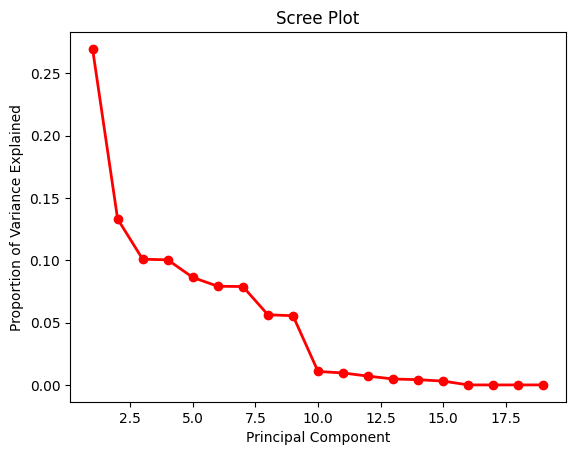


 Number of components to keep: 9


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train_p = pca.fit_transform(X_train)
X_test_p = pca.transform(X_test)

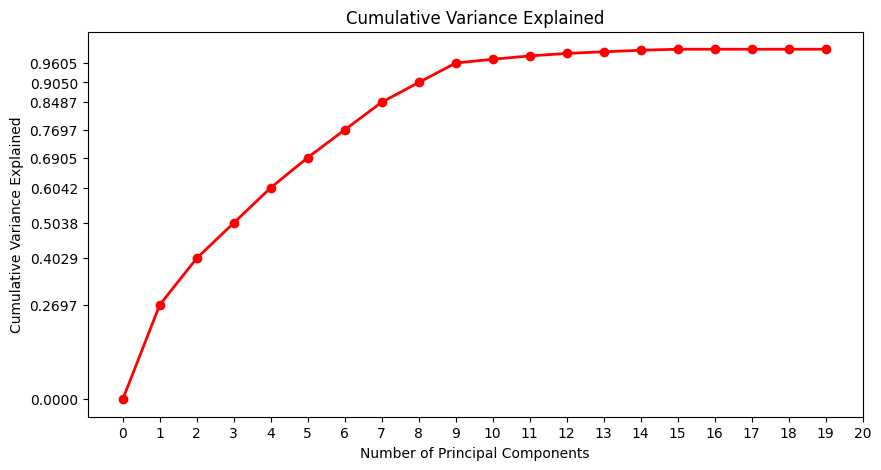

In [57]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()

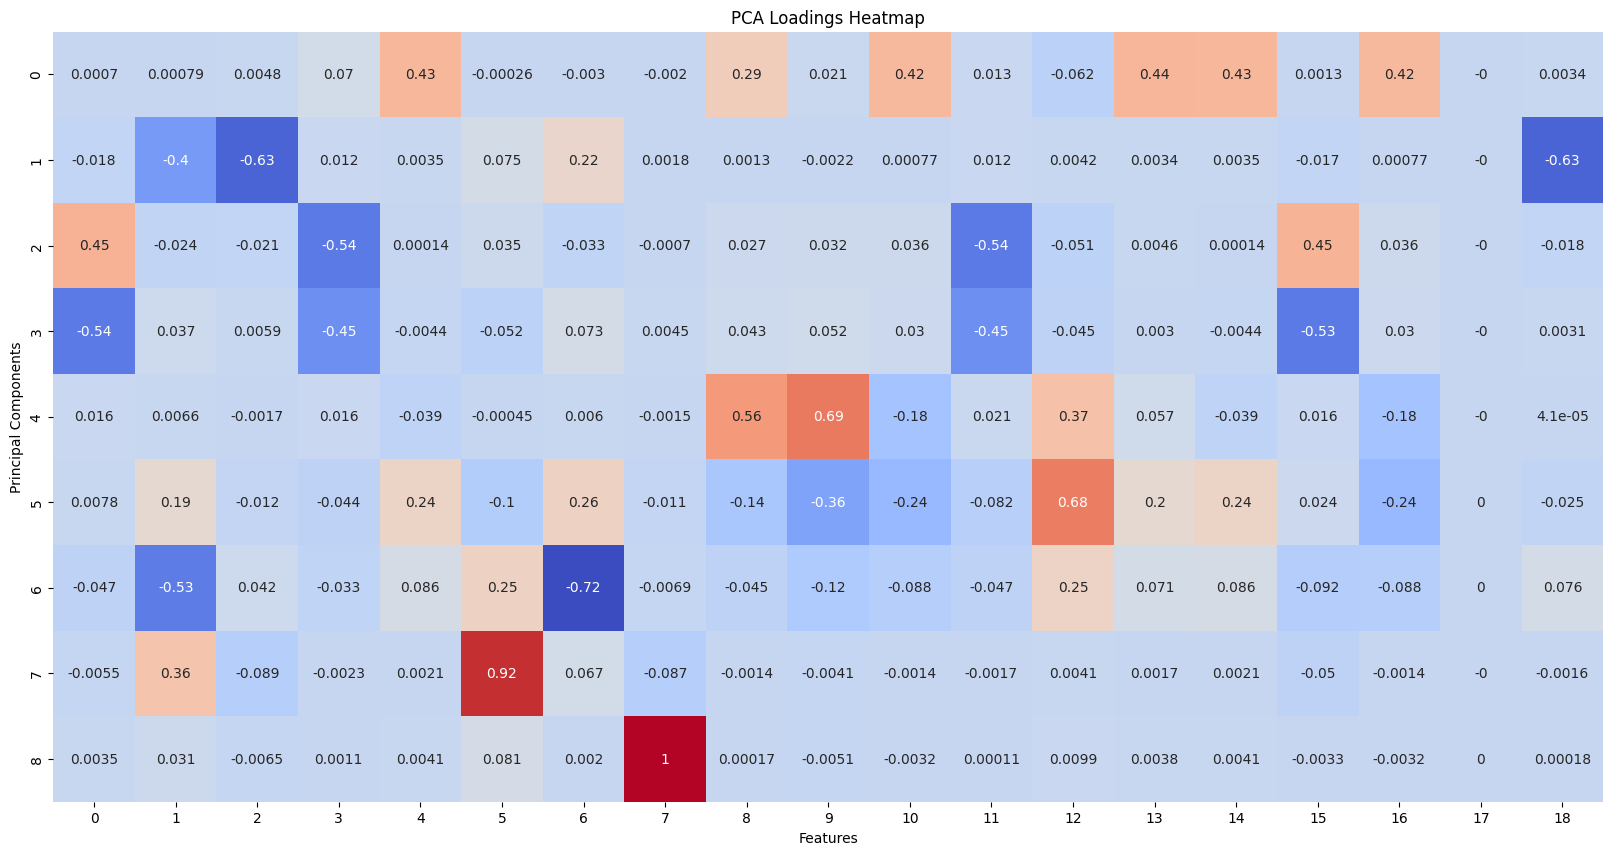

In [58]:
import seaborn as sns

# Heatmap loadings
fig = plt.figure(figsize=(20, 10))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True, cbar=False)
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings Heatmap')
plt.show()

In [59]:
# Get the principal components as vectors in the original feature space
pc_vectors = pca.components_

# Get the names of the original columns
column_names = X.columns

# Print the names of the columns chosen as principal components
num_pcs = pc_vectors.shape[0]
for i in range(num_pcs):
    pc_name = f'PC{i+1}'
    pc_loadings = pc_vectors[i]
    relevant_columns = column_names[np.abs(pc_loadings) >= 0.40]
    print(f'{pc_name}:\n {relevant_columns.tolist()}, \n {pc_loadings[np.abs(pc_loadings) >= 0.40]} \n ')

PC1:
 ['Sales per customer', 'Order Item Product Price', 'Sales', 'Order Item Total', 'Product Price'], 
 [0.4294423  0.41698337 0.43743272 0.4294423  0.41698337] 
 
PC2:
 ['Days for shipment (scheduled)', 'Shipping Mode'], 
 [-0.62694911 -0.62706265] 
 
PC3:
 ['Type', 'Benefit per order', 'Order Item Profit Ratio', 'Order Status'], 
 [ 0.45356897 -0.53610646 -0.54005929  0.45226665] 
 
PC4:
 ['Type', 'Benefit per order', 'Order Item Profit Ratio', 'Order Status'], 
 [-0.53952926 -0.44765827 -0.4526865  -0.53443195] 
 
PC5:
 ['Order Item Discount', 'Order Item Discount Rate'], 
 [0.56200758 0.69144453] 
 
PC6:
 ['Order Item Quantity'], 
 [0.6781656] 
 
PC7:
 ['Days for shipping (real)', 'Late_delivery_risk'], 
 [-0.53112044 -0.72157073] 
 
PC8:
 ['Delivery Status'], 
 [0.92228488] 
 
PC9:
 ['Customer Segment'], 
 [0.99610104] 
 


## Models

In [ ]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

print(X_train.shape, y_train.shape)
print(type(X), type(y))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

fraud = StackingClassifier(estimators=[('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced')),
                                      ('dt', DecisionTreeClassifier(max_depth=4))],
                                              final_estimator=DecisionTreeClassifier(max_depth=5))

fraud1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, class_weight='balanced')

regular = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=4, subsample=0.8)

regular2 = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.0001, l1_ratio=1, max_iter=1000)

suspected = DecisionTreeClassifier(class_weight='balanced', max_depth= 4)

reg_sus = XGBClassifier(objective='multi:softmax', num_class=3, max_depth=4, subsample=0.8,
                    colsample_bytree=0.8, learning_rate=0.3)

### Voting2class1

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize the voting classifier with the base models
model = VotingClassifier(estimators=[('fraud', fraud1), ('reg_sus', reg_sus)], voting='soft')

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/Voting2class1.pkl', 'wb') as file:
    pickle.dump(model, file)

### Voting2class

In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize the voting classifier with the base models
model = VotingClassifier(estimators=[('fraud', fraud), ('reg_sus', reg_sus)], voting='hard')

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/Voting2class.pkl', 'wb') as file:
    pickle.dump(model, file)

### Bagging Logistic

In [ ]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial'),
                  n_estimators=30)

model.fit(X_train, y_train)

with open('/content/drive/MyDrive/University/Deloitte/models/Voting2class.pkl', 'wb') as file:
    pickle.dump(model, file)

## Results

**Best Fraud**

*Voting2class*
```python
VotingClassifier(estimators=[('fraud',
                              StackingClassifier(estimators=[('lr', LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                                                             ('dt', DecisionTreeClassifier(max_depth=4))],
                                                              final_estimator=DecisionTreeClassifier(max_depth=5))),
                             ('reg_sus',
                              XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))])
```
```python
Fraud Recall: 0.9228, std: 0.1951
Average Confusion Matrix: [749 42 2]
```

**Best Suspected**

*Voting2class1*
```python
VotingClassifier(estimators=[('fraud',
                              LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                             ('reg_sus',
                              XGBClassifier(colsample_bytree=0.8,
                                            learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))], 
                  voting='soft')
```
```python
Suspected Recall: 0.8843, std: 0.1285
Average Confusion Matrix: [24 787 6190]
```

**Best Regular**

*Bagging Logistic Model:*
```python
BaggingClassifier(estimator=LogisticRegression(max_iter=1000, multi_class='multinomial'),
                  n_estimators=30)
```
```python
Regular Recall: 0.9585, std: 0.0422
Average Confusion Matrix: [466  27115  708]
```

**Best Overall**
1. *Voting2class1* 

more balanced between the 3 recalls
```python
VotingClassifier(estimators=[('fraud',
                              LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')),
                             ('reg_sus',
                              XGBClassifier(colsample_bytree=0.8,
                                            learning_rate=0.3, max_depth=4, n_estimators=100, num_class=3, objective='multi:softmax'))], 
                  voting='soft')
```
```python
Fraud Recall: 0.8637, std: 0.2231
```
```python
Suspected Recall: 0.8913, std: 0.1258
```
```python
Regular Recall: 0.9366, std: 0.0675
```
```python
Total Recall: 0.8972, std: 0.1322
```
```python
 Average Confusion Matrix:
[[701  87  24]
 [235  26500  1560]
 [25  736  6240]]
```

2. *Voting2class* 

Better on Regular and Fraud, less in Suspected
```python
VotingClassifier(estimators=[('fraud', StackingClassifier(estimators=[('lr', LogisticRegression(class_weight='balanced', max_iter=2000, multi_class='multinomial')), 
                                                                      ('dt', DecisionTreeClassifier(max_depth=4))], 
                                                          final_estimator=DecisionTreeClassifier(max_depth=5))),
                             ('reg_sus',
                              XGBClassifier(learning_rate=0.3, max_depth=4 n_estimators=100, num_class=3, objective='multi:softmax'))])
```

```python
Fraud Recall: 0.9387, std: 0.1318	
```
```python
Suspected Recall: 0.7848, std: 0.0763 
```
```python
Regular Recall: 0.9541, std: 0.0395
```
```python
Total Recall: 0.8925, std: 0.0708
```
```python
 Average Confusion Matrix:
[[762  5  0]
 [625  27000  674]
 [5  1500  5490]]
 ```

### Try the model over 100 different splits

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd

# Standardize the data and split it into training and test sets
s = StandardScaler()

recall_scores = []
precision_scores = []
f1_scores = []
accuracy_scores = []
fraud_recall = []
suspected_recall = []
regular_recall = [] 
low = []
avg_conf_matrix = np.zeros((3, 3))

np.set_printoptions(precision=2)
#StackingXGB

with open('/content/drive/MyDrive/University/Deloitte/bests/Voting2class.pkl', 'rb') as f:
    model = pickle.load(f)

for i in range(1, 101):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

  X_train = s.fit_transform(X_train)
  X_test = s.transform(X_test)

    # PCA
  pca = PCA()
  pca.fit(X_train)

  cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
  num_components_to_keep = np.argmax(cumulative_variance_ratio >= 0.95) + 1

  pca = PCA(n_components=num_components_to_keep)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)

  y_pred = model.predict(X_test)

  conf_matrix = confusion_matrix(y_test, y_pred)

  recalls = []
  for j in range(conf_matrix.shape[0]):
      tp = conf_matrix[j,j]
      fn = np.sum(conf_matrix[j,:]) - tp
      recall = tp / (tp + fn)
      recalls.append(recall)

  recall_scores.append(recall_score(y_test, y_pred, average="macro"))
  fraud_recall.append(recalls[0])
  regular_recall.append(recalls[1])
  suspected_recall.append(recalls[2])

  conf_matrix = confusion_matrix(y_test, y_pred)
  avg_conf_matrix += conf_matrix

  if i % 10 == 0:
      print(f'Iteration: {i}')
      print(f'Fraud Recall {round(np.average(fraud_recall), 4)}, {round(np.std(fraud_recall), 4)}')
      print(f'Suspected Recall {round(np.average(suspected_recall), 4)}, {round(np.std(suspected_recall), 4)}')
      print(f'Regular Recall {round(np.average(regular_recall), 4)}, {round(np.std(regular_recall), 4)}')
      print(f'Total Recall {round(np.average(recall_scores), 4)}, {round(np.std(recall_scores), 4)} \n')

  if recalls[0] < 0.7:
    low.append(round(recalls[0], 4))
  
print(f'\n Fraud Recall: {round(np.average(fraud_recall), 4)}, std: {round(np.std(fraud_recall), 4)}, Under 0.7: {len(low)}, {low}\n Suspected Recall: {round(np.average(suspected_recall), 4)}, std: {round(np.std(suspected_recall), 4)}\n Regular Recall: {round(np.average(regular_recall), 4)}, std: {round(np.std(regular_recall), 4)}\n Total: {round(np.average(recall_scores), 4)}, std: {round(np.std(recall_scores), 4)}')

np.set_printoptions(precision=2)
avg_conf_matrix /= 100
print("\n Average Confusion Matrix:")
print(avg_conf_matrix)

print('\n', model)
